In [1]:
import pandas as pd
import pystan
import numpy as np

In [2]:
from scipy.special import betaln as lbeta
from scipy.special import beta 
from scipy.special import gammaln

def prob_2_beats_1_parameters(alpha_1, beta_1, alpha_2, beta_2):
    total = 0.0
    for i in np.arange(0,alpha_2-1):
        total += np.exp( lbeta(alpha_1+i,beta_1 + beta_2) - np.log(beta_2+i) - lbeta(1+i,beta_2) - lbeta(alpha_1,beta_1))
    return total

def prob_1_diff_2(alpha_1, beta_1, alpha_2, beta_2):
    p = prob_2_beats_1_parameters(alpha_1, beta_1, alpha_2, beta_2)
    return p - (1-p)

def log_beta_binomial_density(k,n,alpha,beta):
    uno = gammaln(n+1) - (gammaln(k+1) + gammaln(n-k+1))
    dos = gammaln(k+alpha) + gammaln(n-k+beta) - gammaln(n+alpha+beta)
    tres = gammaln(alpha + beta) - (gammaln(alpha) + gammaln(beta))
    return uno + dos + tres



In [3]:
from scipy.optimize import minimize
from scipy import logaddexp
        
def beta_mom(mean=None,variance=None):
    """
        Returns the parameters of a beta distributions using the method of moments
    """
    
    common_factor = mean*((1-mean)/variance-1)
    return [mean*common_factor,   (1-mean)*common_factor]

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return (average, np.sqrt(variance))

def beta_pars_from_cdf(cdf_vals = None, x_points=None,weights=None):
    """
        Infers the parameters of a beta distributions starting from the CDF by minimising the first and second moments of the distribution
    """
    m,s2 = weighted_avg_and_std(x_points,weights=cdf_vals)
    
    def beta_pdf_delta(beta_par,local_m=m,local_s2=s2, x_points = x_points, weights=None):
        proposed_cdf = get_beta_cdf([beta_par], x_points=x_points, weights=None) 
        proposed_m, proposed_s2 =  weighted_avg_and_std(x_points, weights= proposed_cdf)
        delta =  (local_m - proposed_m)**2 + (local_s2 - proposed_s2)**2
        return(delta)
    
    x0 = beta_mom(m, s2)
    res = minimize(beta_pdf_delta, x0, method='nelder-mead', options={'xtol': 1e-8,'disp': False})
    back = res.x.astype(list).astype(float)
    return( [back[0],back[1]] )



def get_beta_cdf(pars,x_range=[0,1], x_n_points=500, x_points=None, weights=None):
    """
        For a set of beta distribitions parametrised as [[alpha_1,beta_1],[alpha_2,beta_2]] obtained the conflated distribution.
        See function beta_conflation for more details 
    """
    if weights is None:
        weights = np.ones(len(pars))
    if len(weights) != len(pars):
        raise ValueError('Number of weights must be equal to number of parameters')
    
    weights /= np.max(weights)
    
    if x_points is None:
        x_points = np.linspace(x_range[0], x_range[1], x_n_points)
    it = iter(pars)
    initializer = next(it)

    w_it = iter(weights)
    w_init = next(w_it)
    log_accum_value = ss.beta.logpdf(x_points, initializer[0], initializer[1])
    w_sum = w_init

    for next_pars in it:
        w_value = next(w_it)
        w_prop = w_sum/(w_sum + w_value)
        # log (first^w_prop)*(second/(1-w_prop)) = log(first) - log(w_prop) + log(second) - log((1-w_prop))
        log_accum_value = w_prop*log_accum_value + (1.0-w_prop)*ss.beta.logpdf(x_points, next_pars[0], next_pars[1])
        w_sum += w_value
    return np.exp(log_accum_value - logaddexp.reduce(log_accum_value))


def beta_conflation(pars=None, x_range=[1e-8,1.0-1e-8], x_n_points=500, initializer=None, weights=None):
    """
        Performs conflation on beta distributions following Hill (2011, https://arxiv.org/pdf/0808.1808.pdf) and 
        Hill and Miller (2011, http://dx.doi.org/10.1063/1.3593373)
        
        pars = parameters of the beta distributions list of list where each list provides the pair alpha beta: e.g. [[alpha_1,beta_1],[alpha_2,beta_2]]
        x_range = value range to consider the conflation list of to values [min, max]
        x_n_points= number of points to evalue on the x_range
        initializer = initial set of paramaters to consider 
        weights = weights to combine the differet distributions. Internally will be normalised by dividing by max value as per Hill and Miller (2011)
        
        Return a list of two values [alpha, beta] corrsponding to the parameters of the combined distribution
        
    """
    x_points = np.linspace(x_range[0], x_range[1], x_n_points)
    
    it = iter(pars)
    if initializer is None:
        try:
            initializer = next(it)
        except StopIteration:
            raise TypeError('Sequence with no initial value')
            
    if weights is None:
        weights = np.ones(len(pars))
    if len(weights) != len(pars):
        raise ValueError('Number of weights must be equal to number of parameters')
    
    weights /= np.max(weights)
    
    accum_value = initializer
    
    w_it = iter(weights)
    w_init = next(w_it)
    
    w_sum = w_init
    for next_pars in it:
        w_value = next(w_it)
        cdf_vals = get_beta_cdf([accum_value,next_pars], x_points=x_points, weights=[w_sum, w_value])
        accum_value = beta_pars_from_cdf(cdf_vals, x_points=x_points,weights=weights)
        w_sum += w_value

    return accum_value

In [4]:
def get_mus(K=3, center=0.5, denom_val = 2):
    mus = np.zeros(K)
    center_idx = int(0.5*(K-1))
    mus[ center_idx ] = 0.5
    denominator = np.sqrt(denom_val)
    for i in range(int(K - 0.5*(K-1)),K):
      mus[i] = mus[i-1]/denominator;
      mus[K - i - 1] = 1 - mus[i-1]/denominator;
        
    print(mus)

def get_mus_log(K=3, center=0.5):
    start = np.log(1)
    end=np.log(0.5)
    step= (end - start)/((K-1)/2)
    mus = np.sort(
        np.hstack(
            [np.exp(np.arange(start,end,step)),
            0.5,
            1 - np.exp(np.arange(start,end,step))]
        )
    )

    mus[mus == 0] = 0.01
    mus[mus == 1] = 0.99
    return mus

def get_mu_linear(K=3):
    back = np.sort(np.hstack([np.arange(0,1.0,1.0/(K-1))] + [.99]))
    back[back == 0] = 0.01
    back[back == 1] = 0.99
    #back[back == 0.5] = 0.53


    return back

    
def get_prior_counts(K=3, center_prop=0.9):
    pc = np.ones(K)
    pc[int(0.5*(K-1))] = 10
    return pc

get_mu_linear(K=7)


array([ 0.01      ,  0.16666667,  0.33333333,  0.5       ,  0.66666667,
        0.83333333,  0.99      ])

In [5]:
folders = !ls /Users/inti.pedroso/DATA/ASE/phaser/
data = pd.concat([ pd.read_table("".join(["/Users/inti.pedroso/DATA/ASE/phaser/",f,"/",f,".phaser_ase.gene.txt"])) for f in folders ])


In [6]:
#data = pd.read_table("/Users/inti.pedroso/DATA/ASE/phaser/ERR883767/ERR883767.phaser_ase.gene.txt")
data.head()
data2 = data[data["totalCount"] > 10]
data2.shape

(8194, 12)

### Dirichlet Prios Mixture

$$G \alpha = \sum_{k=1}^{\infty} = DP(\alpha, BB(a_0,b_0))$$

Stick Breaking Prior

$$\pi_c = \upsilon_c \prod_{i=1}^{c-1}(1-\upsilon_i)$$



In [7]:
%%file /Users/inti.pedroso/DATA/ASE/mixture_BBv5.stan
data {
  int<lower=1> N; // total number of observations
  int<lower=1> K; // total number of mixture distributions
  int<lower=0> x[N]; // counts for one allele
  int<lower=0> n[N]; // total counts for unit
  vector<lower=0,upper=1>[K] mu; // means of mixture distributions
}
parameters {
  vector<lower=1.1>[K] M; // M_k = alpha_k + _beta_k. <lower=5,upper=1000>
  real <lower=0.0001,upper=1-0.0001> v[K];
  real <lower=0.0001> alpha_SB;

}

transformed parameters{
  simplex[K] theta; // mixture proportions
  theta[1] = v[1];
  // stick-break process based on The BUGS book Chapter 11 (p.294)
  for(j in 2:(K-1)){
      theta[j]= v[j]*(1-v[j-1])*theta[j-1]/v[j-1]; 
  }
  theta[K]=1-sum(theta[1:(K-1)]); // to make a simplex.
}

model {
  // clusters parameters
  real alpha[K]; 
  real beta[K];
  // parameters for stick breaking prior for mixture coefficients
  vector[K] log_theta = log(theta); // cache log calculation

  // Priors
  alpha_SB ~ gamma(6,1);
  v ~ beta(1,alpha_SB);
  M ~ pareto(1.0, 1.5);

  // alpha and beta parameters for each of the K distributions
  for (k in 1:K) {
    alpha[k] = mu[k]*M[k];
    beta[k] = (1-mu[k])*M[k];
  }

  // likelihood 
  for (i in 1:N) {
    vector[K] lps = log_theta;
    for (k in 1:K) {
      lps[k] += beta_binomial_lpmf(x[i]|n[i], alpha[k], beta[k]);
    }
    target += log_sum_exp(lps);
  } 
}

Overwriting /Users/inti.pedroso/DATA/ASE/mixture_BBv5.stan


In [8]:
%%file /Users/inti.pedroso/DATA/ASE/mixture_BBv4.stan
data {
  int<lower=1> N; // total number of observations
  int<lower=1> K; // total number of mixture distributions
  int<lower=0> x[N]; // counts for one allele
  int<lower=0> n[N]; // total counts for unit
  real<lower=0,upper=1> mu[K]; // means of mixture distributions
}
parameters {
  simplex[K] kappa; // prior count proportions
  real<lower=10,upper=600> dirMass; // Total mass for dirichlet prior
  simplex[K] theta; // mixture proportions
  vector<lower=2>[K] M; // M_k = alpha_k + _beta_k. <lower=5,upper=1000>
} 
model {
  real alpha[K];
  real beta[K];
  vector[K] lambda; // prior pseudocounts for each mixture distribution

  vector[K] log_theta = log(theta); // cache log calculation
  // alpha and beta parameters for each of the K distributions
  for (k in 1:K) {
    alpha[k] = mu[k]*M[k];
    beta[k] = (1-mu[k])*M[k];
    lambda[k] = kappa[k]*dirMass;
  }

  // priors for allocations proportions. This are fixed
  theta ~ dirichlet(lambda);
  // priors for each component 
  M ~ pareto(0.1, 1.5);
    
  // likelihood 
  for (i in 1:N) {
    vector[K] lps = log_theta;
    for (k in 1:K)
      lps[k] += beta_binomial_lpmf(x[i]|n[i], alpha[k], beta[k]);
    target += log_sum_exp(lps);
  } 
}

Overwriting /Users/inti.pedroso/DATA/ASE/mixture_BBv4.stan


In [9]:
data2 = data[data["totalCount"] > 10]
K=21
dat2stan = {'N': data2.shape[0],
            'K':K,
            'mu': get_mu_linear(K),
            'lambda': get_prior_counts(K=K),
            'x': data2.aCount.values,
            'n': data2.totalCount.values
           }
data2.shape

(8194, 12)

In [10]:
get_mu_linear(5)

array([ 0.01,  0.25,  0.5 ,  0.75,  0.99])

In [11]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams['figure.figsize'] = (12, 8)
import scipy.stats as ss

def plot_normal(x_range, mu=0, sigma=1, cdf=False, **kwargs):
    '''
    Plots the normal distribution function for a given x range
    If mu and sigma are not provided, standard normal is plotted
    If cdf=True cumulative distribution is plotted
    Passes any keyword arguments to matplotlib plot function
    '''
    x = x_range
    if cdf:
        y = ss.norm.cdf(x, mu, sigma)
    else:
        y = ss.norm.pdf(x, mu, sigma)
    plt.plot(x, y, **kwargs)
    
def plot_beta(x_range, alpha=1, beta=1, cdf=False, w = 1, color=None, normalise=True, **kwargs):
    '''
    Plots the normal distribution function for a given x range
    If mu and sigma are not provided, standard normal is plotted
    If cdf=True cumulative distribution is plotted
    Passes any keyword arguments to matplotlib plot function
    '''
    x = x_range
    if cdf:
        y = ss.beta.cdf(x, alpha, beta)
    else:
        y = w*ss.beta.pdf(x, alpha, beta)
    if normalise:
        y /= np.sum(y)
    plt.plot(x, y,color=color, **kwargs)

In [ ]:
sm_BB = pystan.StanModel(file="/Users/inti.pedroso/DATA/ASE/mixture_BBv4.stan")




In [ ]:
fit_vb = sm_BB.vb(data=dat2stan, tol_rel_obj = 1e-3)

In [ ]:
sm_BB_DPM = pystan.StanModel(file="/Users/inti.pedroso/DATA/ASE/mixture_BBv5.stan")
#sm_BB_dirPrior = pystan.StanModel(file="/Users/inti.pedroso/DATA/ASE/mixture_BB_dirPrior.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d4dfaa0fad2abedbe421bd219fa5ff26 NOW.


In [184]:
fit_DPM_vb = sm_BB_DPM.vb(data=dat2stan, tol_rel_obj = 1e-3)
#fit_DPM_hmc = sm_BB_DPM.sampling(data=dat2stan, iter=1000, chains=2, n_jobs=1)

/Users/inti.pedroso/anaconda2/envs/ase_dev/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [ ]:
x = np.linspace(0, 1, 500)

model_fit = fit_DPM_vb

Ms = model_fit['mean_pars'][:K]
v = model_fit['mean_pars'][K:(2*K)]
theta = model_fit['mean_pars'][(2*K+1):]



# dirMass = model_fit['mean_pars'][K]
# theta = model_fit['mean_pars'][K+1:(2*K+1)]
# = model_fit['mean_pars'][(2*K+1):]

pars_df = pd.DataFrame([dat2stan['mu'],
                        theta,
                        Ms,
                        dat2stan['mu']*Ms, 
                        (1-dat2stan['mu'])*Ms ],
             index=["mu","theta","M","alpha","beta"]).T

for i in np.arange(len(Ms)):
    m = pars_df.loc[i,"mu"]
    M= pars_df.loc[i,"M"]
    w = 1*pars_df.loc[:,"theta"].values[i]
    plot_beta(x, alpha=m*M,beta=(1-m)*M, w= w, normalise=False)

plt.hist(dat2stan['x']/dat2stan['n'],bins=50, density=True)

In [ ]:
plt.plot(pars_df.mu.values,pars_df.theta.values,'o')

In [406]:
pars_df

,mu,theta,M,alpha,beta
0,0.01,0.000392,1.694409,0.016944,1.677465
1,0.05,0.000434,1.773901,0.088695,1.685206
2,0.10,0.000482,2.165826,0.216583,1.949243
3,0.15,0.000597,2.372132,0.355820,2.016312
4,0.20,0.000851,2.339757,0.467951,1.871806
5,0.25,0.200777,43.103716,10.775929,32.327787
6,0.30,0.002778,5.796832,1.739050,4.057783
7,0.35,0.004507,7.256419,2.539747,4.716672
8,0.40,0.004973,5.854520,2.341808,3.512712
9,0.45,0.007772,6.747228,3.036253,3.710976


In [590]:
data2.head()

,contig,start,stop,name,aCount,bCount,totalCount,log2_aFC,n_variants,variants,gw_phased,bam
5,B07,285804,289743,LOC100645794,8,9,17,-0.169925,1,B07_287747_G_A,0,ERR883767
7,B07,291932,299058,LOC100644253,42,46,88,-0.131245,2,"B07_298584_T_C,B07_298620_C_T",0,ERR883767
10,B07,317746,321001,LOC100649211,11,11,22,0.000000,1,B07_319859_G_A,0,ERR883767
11,B07,321359,323879,LOC100647848,23,15,38,0.616671,1,B07_321560_G_T,0,ERR883767
12,B07,323979,327132,LOC100643240,13,5,18,1.378512,1,B07_325518_G_A,0,ERR883767


In [667]:
def get_pars_list(pars_df):
    pars = list() 
    for i in np.arange(pars_df.shape[0]):
        pars.append([pars_df.loc[i,"alpha"], pars_df.loc[i,"beta"]])
    return pars

def get_mixture_membership(a,b,pars):
    total = a + b
    w = [ log_beta_binomial_density(a,total, p[0],p[0]+p[1]) for p in pars ]
    w -= logaddexp.reduce(w)
    return np.exp(w)



def unit_posterior(a,b, par_list, weights=None, return_originals=True): 
    unit_components = list()
    for i in np.arange(len(par_list)):
        unit_components.append([par_list[i][0] + a ,par_list[i][1] + b])
        
    w = get_mixture_membership(a,b,par_list)
    if weights is not None:
        w = weights * w 

    a_w,b_w = beta_conflation(pars=unit_components, weights=w)
    back = {'alpha_post': a_w, 'beta_post': b_w}
    if return_originals:
        back['a_counts'] = a 
        back['b_counts'] = b 
    return back

from tqdm import tnrange, tqdm_notebook

def get_observation_post( counts, prior_pars, weights=None):
    back = list()
    for i in tnrange(counts.shape[0]):
        back.append( unit_posterior(a=counts[i,0],b=counts[i,1],par_list=prior_pars, weights=weights) )
    return back








In [678]:
pars = get_pars_list(pars_df)
post = get_observation_post( data2.loc[:,["aCount","bCount"]].drop_duplicates().values,
                            prior_pars = pars,
                            weights = pars_df.theta.values)
post = pd.DataFrame(post, columns=['a_counts','b_counts','alpha_post','beta_post'])



In [679]:
post.head()


,a_counts,b_counts,alpha_post,beta_post
0,8,9,87.556263,79.660169
1,42,46,78.909102,72.377880
2,11,11,79.987954,70.387293
3,23,15,43.209366,27.025607
4,13,5,37.987341,21.722518


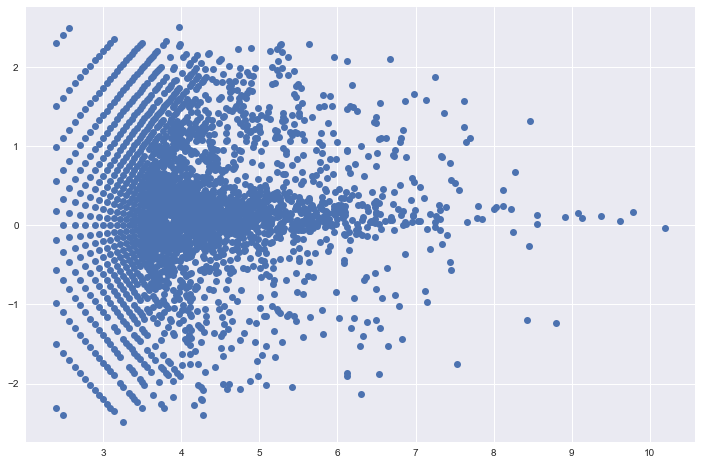

In [680]:
plt.plot(np.log(post.a_counts + post.b_counts), np.log(post.a_counts /post.b_counts),'o')

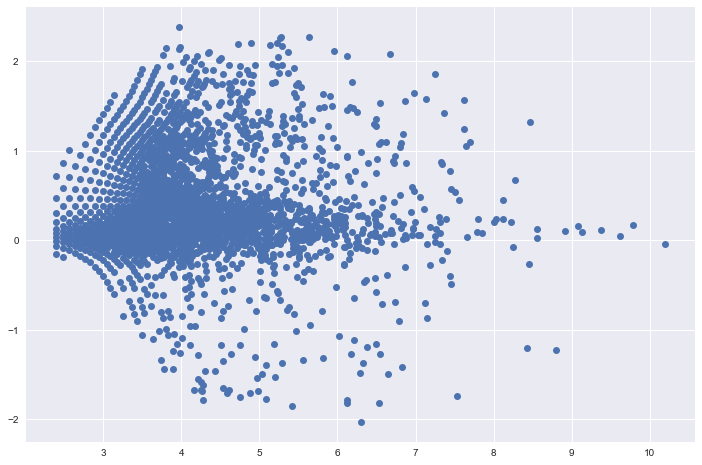

In [681]:
plt.plot(np.log(post.a_counts + post.b_counts), np.log(post.alpha_post/post.beta_post),'o')

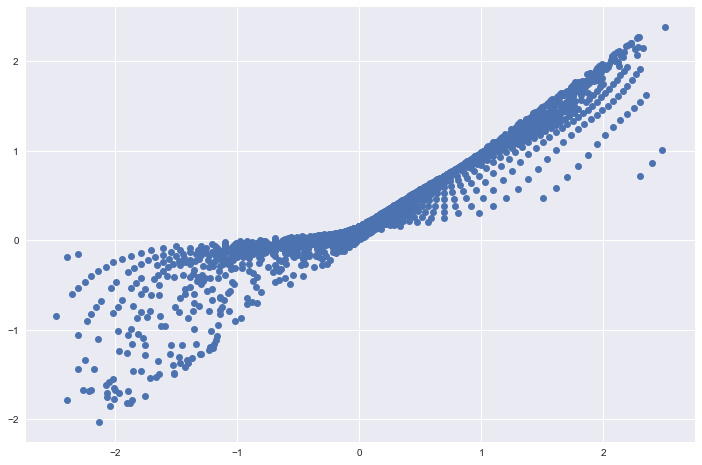

In [682]:
plt.plot(np.log(post.a_counts / post.b_counts), np.log(post.alpha_post/post.beta_post),'o')

(array([  1.,   0.,   6.,   6.,   5.,   4.,   7.,   7.,   7.,  10.,   5.,
          6.,   5.,  12.,  11.,  11.,  16.,  15.,  21.,  33.,  48., 100.,
        177., 279., 222., 195., 165., 131.,  95.,  70.,  56.,  58.,  54.,
         52.,  56.,  65.,  46.,  46.,  42.,  35.,  25.,  25.,  24.,  17.,
         15.,  10.,  11.,   8.,   3.,   1.]),
 array([-2.03137627e+00, -1.94296992e+00, -1.85456358e+00, -1.76615723e+00,
        -1.67775089e+00, -1.58934454e+00, -1.50093819e+00, -1.41253185e+00,
        -1.32412550e+00, -1.23571916e+00, -1.14731281e+00, -1.05890647e+00,
        -9.70500121e-01, -8.82093776e-01, -7.93687430e-01, -7.05281084e-01,
        -6.16874739e-01, -5.28468393e-01, -4.40062048e-01, -3.51655702e-01,
        -2.63249357e-01, -1.74843011e-01, -8.64366656e-02,  1.96967999e-03,
         9.03760255e-02,  1.78782371e-01,  2.67188717e-01,  3.55595062e-01,
         4.44001408e-01,  5.32407753e-01,  6.20814099e-01,  7.09220444e-01,
         7.97626790e-01,  8.86033136e-01,  9.74439

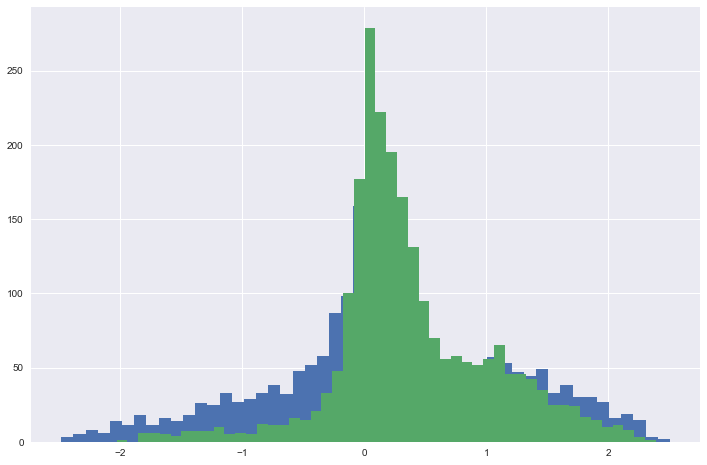

In [686]:
plt.hist(np.log(post.a_counts /post.b_counts),bins=50)
plt.hist(np.log(post.alpha_post/post.beta_post),bins=50)

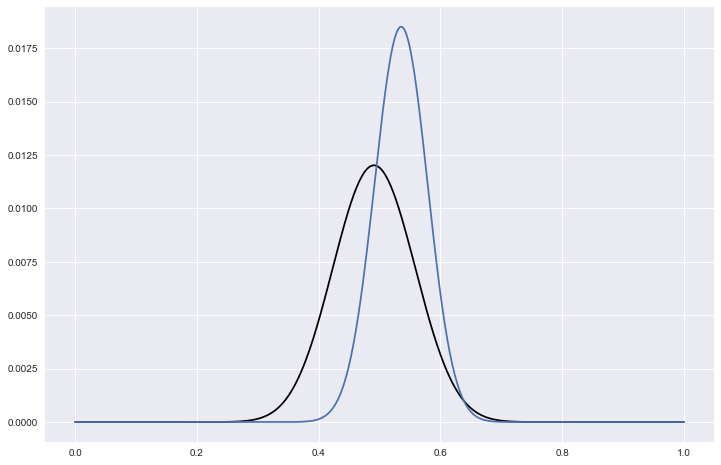

In [634]:
plot_beta(x,28  ,   29, color="black")
plot_beta(x,71.6306169105109, 62.241636423534025)



array([5.62195600e-04, 2.80821438e-03, 5.53677552e-03, 8.37844774e-03,
       1.14116024e-02, 2.70461905e-05, 1.51327929e-02, 1.77963759e-02,
       2.46097185e-02, 2.93418742e-02, 9.68596782e-05, 4.12377134e-02,
       2.79037301e-03, 5.77344601e-02, 7.10284127e-02, 3.39522082e-02,
       3.46460572e-02, 3.57759202e-02, 3.53558379e-02, 3.49812780e-02,
       3.67958363e-02, 5.62195600e-04, 2.80821438e-03, 5.53677552e-03,
       8.37844774e-03, 1.14116024e-02, 2.70461905e-05, 1.51327929e-02,
       1.77963759e-02, 2.46097185e-02, 2.93418742e-02, 9.68596782e-05,
       4.12377134e-02, 2.79037301e-03, 5.77344601e-02, 7.10284127e-02,
       3.39522082e-02, 3.46460572e-02, 3.57759202e-02, 3.53558379e-02,
       3.49812780e-02, 3.67958363e-02])

In [564]:
from scipy.special import beta as Beta
from scipy.special import comb
from scipy import stats as ss
alpha_ = 138.43377090243672
beta_ = 138.43377090243672
a = 1
b = 10
comb(a+b, a)  * Beta(alpha + a, beta + b) / Beta(alpha, beta)

import scipy

In [570]:
np.exp(log_beta_binomial_density(k=199,n=200,alpha=50,beta=50))

7.810233845074794e-28

In [565]:
np.log(scipy.misc.comb(b, a)) + ss.beta.logpdf(a/(a+b),alpha_ +a , beta_ + b)  - ss.beta.logpdf(a/(a+b),alpha_, beta_ )

/Users/inti.pedroso/anaconda2/envs/ase_dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  """Entry point for launching an IPython kernel.


6.454519397278034

In [578]:
from scipy.special import betaln

def log_beta_binomial_probability(k,n,alpha,beta):
    return np.log(comb(n,k)) + betaln(k+alpha,n-k+beta) - betaln(alpha,beta)

log_beta_binomial_probability(138,138*2, 138,138)

-3.383924067719363

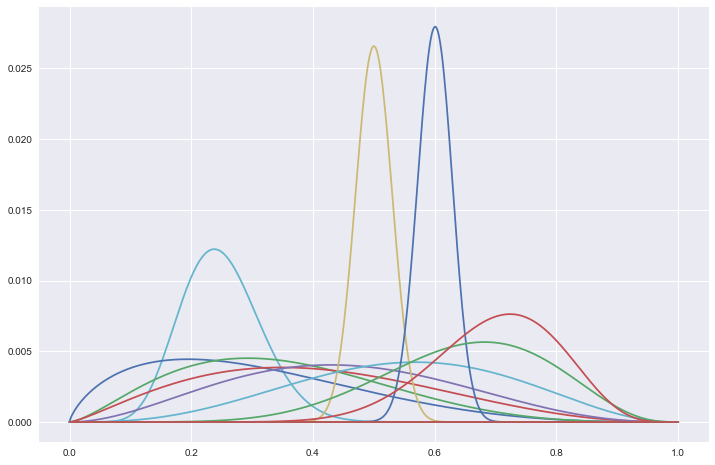

In [461]:
g = list()
pars = list()
gene_a = 30
gene_b = 70

for i in np.arange(pars_df.shape[0]):
    pars.append([pars_df.loc[i,"alpha"], pars_df.loc[i,"beta"]])
    
for i in np.arange(pars_df.shape[0]):
    g.append([pars_df.loc[i,"alpha"] + gene_a ,pars_df.loc[i,"beta"] + gene_b])
    
w = pars_df.theta.values
x = np.linspace(0, 1, 500)
for i in np.arange(len(g)):
    plot_beta(x,alpha=pars[i][0],beta=pars[i][1], w=w[i],normalise=True)



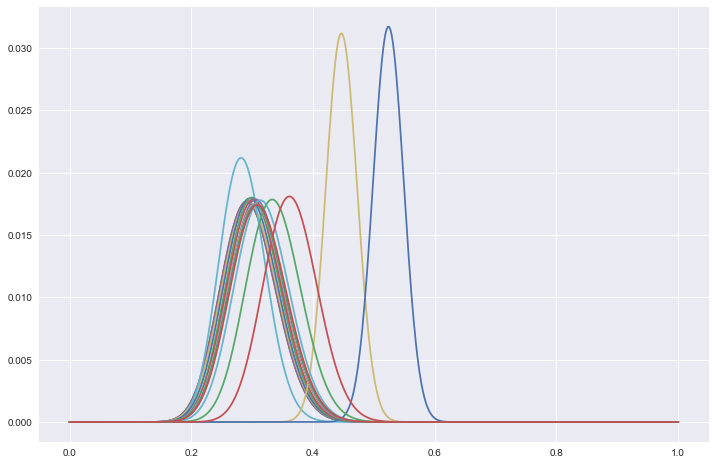

In [462]:
for i in np.arange(len(g)):
    plot_beta(x,alpha=g[i][0],beta=g[i][1], w=w[i],normalise=True)

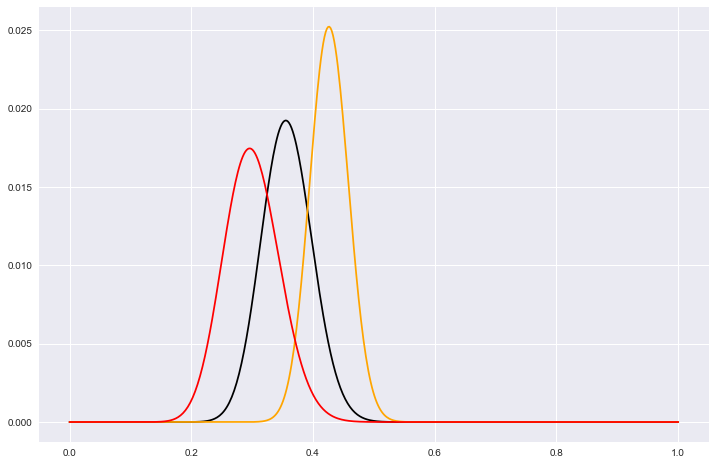

In [464]:
a,b = beta_conflation(pars=g)
y = get_beta_cdf([[a,b]]) 
plt.plot(x,y,color="black")

w3 = pars_df.theta.values*w2
w3 /= np.sum(w3)
a_w,b_w = beta_conflation(pars=g, weights=w3)
y = get_beta_cdf([[a_w,b_w]]) 
plt.plot(x,y,color="orange")

y = get_beta_cdf([[gene_a,gene_b]]) 
plt.plot(x,y,color="red")

In [465]:
beta_conflation(pars)

[17.59665747583585, 15.33775304906446]

In [478]:
prob_1_diff_2(a_w,b_w,138.43377090243672, 138.43377090243672)

0.9028482716703063

In [220]:
beta_conflation(pars=g, x_range=[0,1])

/Users/inti.pedroso/anaconda2/envs/ase_dev/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log


[29.717356076248265, 20.98257481017648]

In [345]:
gene_a/(gene_b + gene_a)

0.6837606837606838

In [475]:
pars[int(0.5*(K-1))],pro

[138.43377090243672, 138.43377090243672]

/Users/inti.pedroso/anaconda2/envs/ase_dev/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log


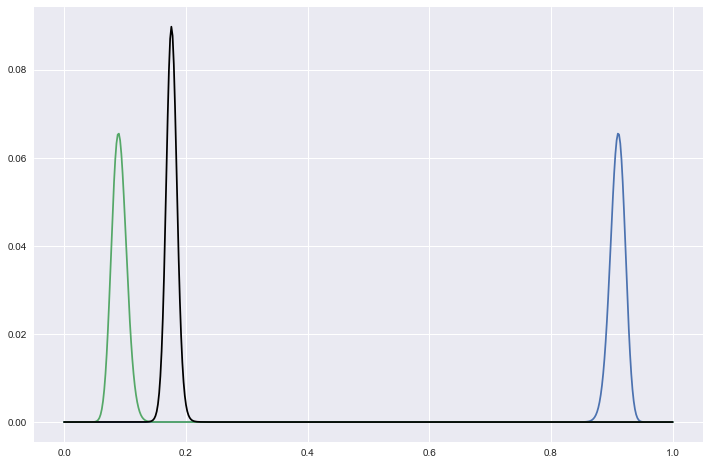

In [195]:
pars=[[500, 50],[50, 500]]
a,b = beta_conflation(pars=pars, x_range=[0,1], weights=[10,100])
x = np.linspace(0, 1, 500)
for p in pars:
    plot_beta(x,alpha=p[0],beta=p[1])

y = get_beta_cdf([[a,b]]) 
plt.plot(x,y,color="black")

In [ ]:
from scipy.special import gammaln
from scipy.misc import logsumexp

def log_dbetabinomial(x,n,a,b):
    return gammaln(n+1) + gammaln(x+a) + gammaln(n-x+b) + gammaln(a+b) - \
        (gammaln(x+1) + gammaln(n-x+1) + gammaln(a) + gammaln(b) + gammaln(n+a+b))

log_dbetabinomial(10,50,25,25)

class DirMult:
    def __init__(self,K=3,prior_counts = None):
        if prior_counts is not None:
            self.prior_counts = prior_counts
        else: 
            self.prior_counts = np.ones(K)
        
        self.alpha = self.prior_counts

    
    def update(self,counts = None):
        self.alpha += counts
            
d = dirich(prior_counts=pr_ct)
print(d.prior_counts)
d.update(pr_ct)
print(d.alpha)

